In [4]:
from cocoPoolDataset import CocoDetection

In [ ]:
# !pip install supervision==0.3.0
# !pip install pycocotools
# !pip install pytorch_lightning
# !pip install jupyter

In [6]:
from transformers import DetrImageProcessor
import supervision as sv

In [7]:
import os

print("Train, Validation, Test")
len(os.listdir("/kaggle/input/dataset/dataset-DETR/train")), len(os.listdir("/kaggle/input/dataset/dataset-DETR/valid")), len(os.listdir("/kaggle/input/dataset/dataset-DETR/test"))

Train, Validation, Test


(4968, 1407, 725)

In [ ]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [9]:
TRAIN_DATASET = CocoDetection(
    img_folder="/kaggle/input/dataset/dataset-DETR/train",
    processor=image_processor,
    train=True
)

VAL_DATASET = CocoDetection(
    img_folder="/kaggle/input/dataset/dataset-DETR/valid",
    processor=image_processor,
    train=False
)

TEST_DATASET = CocoDetection(
    img_folder="/kaggle/input/dataset/dataset-DETR/test",
    processor=image_processor,
    train=False
)

print(f"Train dataset size: {len(TRAIN_DATASET)}")
print(f"Validation dataset size: {len(VAL_DATASET)}")
print(f"Test dataset size: {len(TEST_DATASET)}")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Train dataset size: 4967
Validation dataset size: 1406
Test dataset size: 724


Image n°810


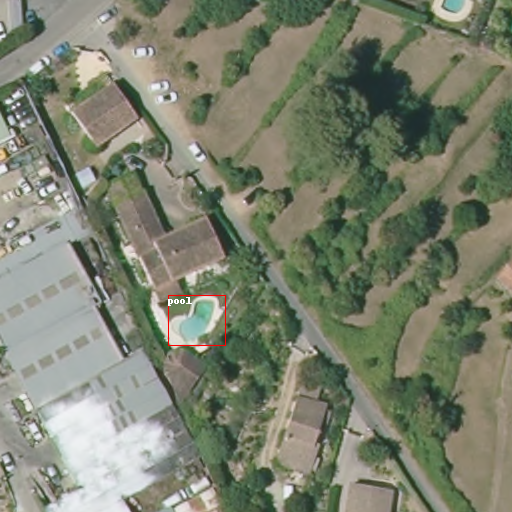

In [10]:
import numpy as np
import os
from PIL import Image, ImageDraw


image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/kaggle/input/dataset/dataset-DETR/train', image['file_name']))

annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

In [35]:
# Prepare data

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels
    }


train_loader = DataLoader(dataset=TRAIN_DATASET, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=3)
val_loader = DataLoader(dataset=VAL_DATASET, batch_size=16, collate_fn=collate_fn, num_workers=3)
test_loader = DataLoader(dataset=TEST_DATASET, batch_size=16, collate_fn=collate_fn, num_workers=3)

In [36]:
batch = next(iter(train_loader))

In [37]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [38]:
pixel_values, target = TRAIN_DATASET[4]

pixel_values.shape

torch.Size([3, 800, 800])

In [39]:
print(target)

{'size': tensor([800, 800]), 'image_id': tensor([4]), 'class_labels': tensor([1]), 'boxes': tensor([[0.2987, 0.9770, 0.1675, 0.0460]]), 'area': tensor([4932.7563]), 'iscrowd': tensor([0]), 'orig_size': tensor([224, 224])}


# Train the model using PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library.

In [44]:

import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                         revision="no_timm",
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
          {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
          {
              "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
              "lr": self.lr_backbone,
          },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                              weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader



In [49]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
outputs.logits.shape

torch.Size([16, 100, 3])

In [51]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 100

trainer = Trainer(accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, log_every_n_steps=100, check_val_every_n_epoch=5)

trainer.fit(model)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [54]:
MODEL_PATH = "detr-coco"
model.model.save_pretrained(MODEL_PATH)

# # loading model
# model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
# model.to(device)

In [94]:
import numpy as np

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    union = area_box1 + area_box2 - intersection
    
    iou = intersection / union
    return iou

def denormalize_bbox(bbox, image_width, image_height):
    
    x, y, width, height = bbox
    x_min = int(x * image_width)
    y_min = int(y * image_height)
    box_width = int(width * image_width)
    box_height = int(height * image_height)
    x_max = x_min + box_width
    y_max = y_min + box_height
    denormalized_bbox = [x_min, y_min, x_max, y_max]
    return denormalized_bbox
    
def evaluate_detections(pred_boxes, gt_boxes, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0
    matched_gt_boxes = set()
    
    for pred_box in pred_boxes:
        matched = False
        for gt_box in gt_boxes:
            if compute_iou(pred_box, gt_box) >= iou_threshold:
                if gt_box not in matched_gt_boxes:
                    TP += 1
                    matched_gt_boxes.add(gt_box)
                    matched = True
                    break
        if not matched:
            FP += 1
    
    FN = max(len(gt_boxes) - len(matched_gt_boxes), 0)
    TP = min(len(gt_boxes), TP)
    return TP, FP, FN

def calculate_metrics(TP, FP, FN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def calculate_accuracy(TP, FP, FN):
    total_predictions = TP + FP
    total_ground_truths = TP + FN
    accuracy = TP / (total_predictions + total_ground_truths - TP) if (total_predictions + total_ground_truths - TP) > 0 else 0
    return accuracy

def evaluate_model(model, dataloader, device, iou_threshold=0.5, min_confidence = 0.8):
    model.eval()
    TP, FP, FN = 0, 0, 0

    with torch.no_grad():

        for data in dataloader:

            imgs = torch.stack([img.to(device) for img in data['pixel_values']])
            pixel_masks = torch.stack([pixel_mask.to(device) for pixel_mask in data['pixel_mask']])
            targets = [{'boxes': label['boxes'].to(device), 'labels': label['class_labels'].to(device)} for label in data['labels']]
            size= data['labels'][0]['orig_size'][0]

            outputs = model(imgs,pixel_masks)
  
            for i in range(len(imgs)):

                pred_boxes = outputs['pred_boxes'][i]
                scores = outputs['logits'][i][:, 1]  # Assuming the second element of logits represents the confidence for object presence
                high_score_indices = scores >= min_confidence

                pred_boxes = pred_boxes[high_score_indices]
                gt_boxes = targets[i]['boxes']

                tp, fp, fn = evaluate_detections(pred_boxes, gt_boxes, iou_threshold)
                TP += tp
                FP += fp
                FN += fn
                

    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    accuracy = calculate_accuracy(TP, FP, FN)
    
    return precision, recall, f1_score, accuracy

In [95]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(device)

precision, recall, f1_score, accuracy = evaluate_model(model, test_loader, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7721
Recall: 0.9009
F1 Score: 0.8316
Accuracy: 0.7117
